# 2 - MNIST CNN Network

Adapted from this tutorial -> https://victorzhou.com/blog/keras-cnn-tutorial/#the-full-code

`github.com/samph4`

~

### Preface

This example will use the same MNIST dataset as we used in the last example. However, this time we are going to train a different class of neural network. This time, we'll be using a Convolutional Neural Network (CNN). CNN's are extremely popular recently as they have revolutionised the field of computer vision as they are well equipped to deal with and process data in image format. There is an article by Victor Zhou (https://victorzhou.com/blog/intro-to-cnns-part-1/) that does an excellent job introducing what a CNN is, but I'll try and summarise his key points here.

A classic use of CNNs is to perform image classification e.g. looking at an image of a pet and determining whether it is a cat or a dog. CNN's can achieve extraordinary results in this regard and some of the most successful and popular CNN networks achieve accuracies of over 88 % on famous image databases such as ImageNet that contains over 14 million images  belonging to ~22,000 categories (where one category might be a cat). You can quickly begin to appreciate the capabilities of these networks and the tasks they might be able to perform. It is a fantastic time to get into machine learning since large improvements in the field have been made in the last 10 years: the image below shows the progression of the 'state of the art' trained networks on the ImageNet database (taken from https://paperswithcode.com/sota/image-classification-on-imagenet).

![Image](./Figures/cnn_exp.png)

Determining whether or not an image is of a cat or a dog seems straight forward, couldn't we just use a standard neural network (MLP)? The answer is yes, but it might be an extremely inefficient solution. The reason being that images can be very big (depending on pixel size). 

> "Images used for Computer Vision problems nowadays are often 224x224 or larger. Imagine building a neural network to process 224x224 color images: including the 3 color channels (RGB) in the image, that comes out to 224 x 224 x 3 = 150,528 input features! A typical hidden layer in such a network might have 1024 nodes, so we’d have to train 150,528 x 1024 = 150+ million weights for the first layer alone. Our network would be huge and nearly impossible to train." - https://victorzhou.com/blog/intro-to-cnns-part-1/.

This is exactly what we did in the previous example, where we took the 28x28 input image (MNIST digit) and flattened it to form a feature vector of 784 elements. This quickly gets out of hand with larger image sizes and as a result training times and convergence can suffer. Nor is it the most logical approach. Intuitively, when we consider an image we interpret the image based on a collection of pixels. Pixels are most useful in the context of their neighbours and as humans we gather much more information from a collection of pixels rather than isolated, indivudal colours. Objects in images are made up of small, *localised* features, like the circular iris of an eye or the square corner of a piece of paper. Doesn't it seem wasteful for every node in the first hidden layer to look at every single pixel? Could it therefore be helpful to try and create something that adopts similar practicices? Also, positions can change. And this is particularly important. If we train a network that is capable of identifying a cat, we would want the model to be able to detect that cat regardless of where it appears in the image.

> "Imagine training a network that works well on a certain dog image, but then feeding it a slightly shifted version of the same image. The dog would not activate the same neurons, so the network would react completely differently!". - https://victorzhou.com/blog/intro-to-cnns-part-1/.

We did not run into this problem in the previous example since the MNIST dataset had been structured for us. The dataset contains small images (low # of pixels = low # of features) that, more imporantly, had been centered so we did not encounter the issue of shifting or funky orientations.

~

## What are CNNs?

![Image](./Figures/cnn.jpeg)

~ bunch of text about how they work - refer to video honestly.

In [1]:
!pip install mnist

#### Necessary Imports

In [2]:
import numpy as np 
from tensorflow import keras 
#from keras.datasets import mnist
import mnist # import mnist directly to access more info
import matplotlib.pyplot as plt

In [3]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

print(train_images.shape) # (60000, 28, 28)
print(train_labels.shape) # (60000,)

(60000, 28, 28)
(60000,)


Before we begin, we’ll normalize the image pixel values from [0, 255] to [-0.5, 0.5] to make our network easier to train (using smaller, centered values usually leads to better results). We’ll also reshape each image from (28, 28) to (28, 28, 1) because Keras requires the third dimension.

In [4]:
# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (60000, 28, 28, 1)
print(test_images.shape)  # (10000, 28, 28, 1)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

num_filters = 8
filter_size = 3
pool_size = 2

model = Sequential()

model.add(Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.keras.utils import to_categorical

model.fit(train_images,to_categorical(train_labels), epochs=3,validation_data=(test_images, to_categorical(test_labels)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3


   32/60000 [..............................] - ETA: 1:29:12 - loss: 2.3406 - accuracy: 0.0000e+00

  704/60000 [..............................] - ETA: 4:04 - loss: 2.1558 - accuracy: 0.2969       

 1536/60000 [..............................] - ETA: 1:52 - loss: 1.9378 - accuracy: 0.4551

 2368/60000 [>.............................] - ETA: 1:13 - loss: 1.6695 - accuracy: 0.5591

 3168/60000 [>.............................] - ETA: 54s - loss: 1.4492 - accuracy: 0.6209 

 4064/60000 [=>............................] - ETA: 42s - loss: 1.2708 - accuracy: 0.6651

 4864/60000 [=>............................] - ETA: 35s - loss: 1.1478 - accuracy: 0.6961

 5568/60000 [=>............................] - ETA: 31s - loss: 1.0677 - accuracy: 0.7144

 6304/60000 [==>...........................] - ETA: 27s - loss: 0.9977 - accuracy: 0.7327

 7136/60000 [==>...........................] - ETA: 24s - loss: 0.9301 - accuracy: 0.7499

 8000/60000 [===>..........................] - ETA: 21s - loss: 0.8730 - accuracy: 0.7632

 8800/60000 [===>..........................] - ETA: 19s - loss: 0.8291 - accuracy: 0.7751

 9504/60000 [===>..........................] - ETA: 18s - loss: 0.7911 - accuracy: 0.7848



10208/60000 [====>.........................] - ETA: 17s - loss: 0.7621 - accuracy: 0.7919

10496/60000 [====>.........................] - ETA: 16s - loss: 0.7527 - accuracy: 0.7946

11104/60000 [====>.........................] - ETA: 16s - loss: 0.7322 - accuracy: 0.8008

11840/60000 [====>.........................] - ETA: 15s - loss: 0.7075 - accuracy: 0.8076

12736/60000 [=====>........................] - ETA: 13s - loss: 0.6788 - accuracy: 0.8156



13568/60000 [=====>........................] - ETA: 12s - loss: 0.6564 - accuracy: 0.8215

14240/60000 [======>.......................] - ETA: 12s - loss: 0.6386 - accuracy: 0.8262

14848/60000 [======>.......................] - ETA: 11s - loss: 0.6246 - accuracy: 0.8303

15488/60000 [======>.......................] - ETA: 11s - loss: 0.6117 - accuracy: 0.8340

16128/60000 [=======>......................] - ETA: 10s - loss: 0.5983 - accuracy: 0.8371

16800/60000 [=======>......................] - ETA: 10s - loss: 0.5878 - accuracy: 0.8397

17280/60000 [=======>......................] - ETA: 10s - loss: 0.5813 - accuracy: 0.8414

17728/60000 [=======>......................] - ETA: 9s - loss: 0.5757 - accuracy: 0.8427 

18432/60000 [========>.....................] - ETA: 9s - loss: 0.5662 - accuracy: 0.8449

19072/60000 [========>.....................] - ETA: 9s - loss: 0.5579 - accuracy: 0.8469

19872/60000 [========>.....................] - ETA: 8s - loss: 0.5465 - accuracy: 0.8503

20512/60000 [=========>....................] - ETA: 8s - loss: 0.5394 - accuracy: 0.8519



21248/60000 [=========>....................] - ETA: 8s - loss: 0.5321 - accuracy: 0.8539

22016/60000 [==========>...................] - ETA: 7s - loss: 0.5245 - accuracy: 0.8556

22848/60000 [==========>...................] - ETA: 7s - loss: 0.5156 - accuracy: 0.8578

23712/60000 [==========>...................] - ETA: 7s - loss: 0.5071 - accuracy: 0.8599

24512/60000 [===========>..................] - ETA: 6s - loss: 0.4988 - accuracy: 0.8621

25312/60000 [===========>..................] - ETA: 6s - loss: 0.4939 - accuracy: 0.8636

26176/60000 [============>.................] - ETA: 6s - loss: 0.4869 - accuracy: 0.8650

27008/60000 [============>.................] - ETA: 5s - loss: 0.4803 - accuracy: 0.8673

27840/60000 [============>.................] - ETA: 5s - loss: 0.4736 - accuracy: 0.8689

28608/60000 [=============>................] - ETA: 5s - loss: 0.4672 - accuracy: 0.8705

29408/60000 [=============>................] - ETA: 5s - loss: 0.4619 - accuracy: 0.8717

30176/60000 [==============>...............] - ETA: 4s - loss: 0.4554 - accuracy: 0.8735

30816/60000 [==============>...............] - ETA: 4s - loss: 0.4522 - accuracy: 0.8742

31552/60000 [==============>...............] - ETA: 4s - loss: 0.4478 - accuracy: 0.8752

32384/60000 [===============>..............] - ETA: 4s - loss: 0.4433 - accuracy: 0.8762

33152/60000 [===============>..............] - ETA: 4s - loss: 0.4391 - accuracy: 0.8775

33920/60000 [===============>..............] - ETA: 4s - loss: 0.4362 - accuracy: 0.8781

34656/60000 [================>.............] - ETA: 3s - loss: 0.4327 - accuracy: 0.8788

35360/60000 [================>.............] - ETA: 3s - loss: 0.4287 - accuracy: 0.8799

36064/60000 [=================>............] - ETA: 3s - loss: 0.4246 - accuracy: 0.8812

36832/60000 [=================>............] - ETA: 3s - loss: 0.4209 - accuracy: 0.8821

37632/60000 [=================>............] - ETA: 3s - loss: 0.4169 - accuracy: 0.8831

38464/60000 [==================>...........] - ETA: 3s - loss: 0.4136 - accuracy: 0.8840

39264/60000 [==================>...........] - ETA: 2s - loss: 0.4102 - accuracy: 0.8849

40000/60000 [===================>..........] - ETA: 2s - loss: 0.4071 - accuracy: 0.8858

40768/60000 [===================>..........] - ETA: 2s - loss: 0.4035 - accuracy: 0.8867

41568/60000 [===================>..........] - ETA: 2s - loss: 0.4007 - accuracy: 0.8877

42368/60000 [====================>.........] - ETA: 2s - loss: 0.3973 - accuracy: 0.8885

43168/60000 [====================>.........] - ETA: 2s - loss: 0.3944 - accuracy: 0.8893

43968/60000 [====================>.........] - ETA: 2s - loss: 0.3916 - accuracy: 0.8902



44768/60000 [=====================>........] - ETA: 2s - loss: 0.3881 - accuracy: 0.8912

45504/60000 [=====================>........] - ETA: 1s - loss: 0.3858 - accuracy: 0.8919

46304/60000 [======================>.......] - ETA: 1s - loss: 0.3824 - accuracy: 0.8928

47104/60000 [======================>.......] - ETA: 1s - loss: 0.3802 - accuracy: 0.8933

47936/60000 [======================>.......] - ETA: 1s - loss: 0.3771 - accuracy: 0.8943

48768/60000 [=======================>......] - ETA: 1s - loss: 0.3745 - accuracy: 0.8949

49536/60000 [=======================>......] - ETA: 1s - loss: 0.3721 - accuracy: 0.8955

50336/60000 [========================>.....] - ETA: 1s - loss: 0.3698 - accuracy: 0.8961

51136/60000 [========================>.....] - ETA: 1s - loss: 0.3674 - accuracy: 0.8967

51936/60000 [========================>.....] - ETA: 0s - loss: 0.3651 - accuracy: 0.8972

52736/60000 [=========================>....] - ETA: 0s - loss: 0.3638 - accuracy: 0.8974

53504/60000 [=========================>....] - ETA: 0s - loss: 0.3618 - accuracy: 0.8979

54304/60000 [==========================>...] - ETA: 0s - loss: 0.3597 - accuracy: 0.8985

55040/60000 [==========================>...] - ETA: 0s - loss: 0.3580 - accuracy: 0.8989

55840/60000 [==========================>...] - ETA: 0s - loss: 0.3554 - accuracy: 0.8997

56512/60000 [===========================>..] - ETA: 0s - loss: 0.3539 - accuracy: 0.9000

57216/60000 [===========================>..] - ETA: 0s - loss: 0.3517 - accuracy: 0.9007

58048/60000 [============================>.] - ETA: 0s - loss: 0.3495 - accuracy: 0.9015

58880/60000 [============================>.] - ETA: 0s - loss: 0.3474 - accuracy: 0.9020

59712/60000 [============================>.] - ETA: 0s - loss: 0.3454 - accuracy: 0.9026

60000/60000 [==============================] - 8s 128us/sample - loss: 0.3445 - accuracy: 0.9028 - val_loss: 0.1827 - val_accuracy: 0.9476


Epoch 2/3
   32/60000 [..............................] - ETA: 3s - loss: 0.4128 - accuracy: 0.9062

  832/60000 [..............................] - ETA: 3s - loss: 0.2032 - accuracy: 0.9423

 1632/60000 [..............................] - ETA: 3s - loss: 0.1894 - accuracy: 0.9436

 2432/60000 [>.............................] - ETA: 3s - loss: 0.1817 - accuracy: 0.9474

 3232/60000 [>.............................] - ETA: 3s - loss: 0.1770 - accuracy: 0.9474

 4032/60000 [=>............................] - ETA: 3s - loss: 0.1849 - accuracy: 0.9467

 4800/60000 [=>............................] - ETA: 3s - loss: 0.1884 - accuracy: 0.9460

 5632/60000 [=>............................] - ETA: 3s - loss: 0.1885 - accuracy: 0.9473



 6400/60000 [==>...........................] - ETA: 3s - loss: 0.1896 - accuracy: 0.9459

 7168/60000 [==>...........................] - ETA: 3s - loss: 0.1862 - accuracy: 0.9467

 7968/60000 [==>...........................] - ETA: 3s - loss: 0.1840 - accuracy: 0.9474

 8736/60000 [===>..........................] - ETA: 3s - loss: 0.1847 - accuracy: 0.9472



 9536/60000 [===>..........................] - ETA: 3s - loss: 0.1852 - accuracy: 0.9473

10304/60000 [====>.........................] - ETA: 3s - loss: 0.1863 - accuracy: 0.9466

11040/60000 [====>.........................] - ETA: 3s - loss: 0.1875 - accuracy: 0.9462

11808/60000 [====>.........................] - ETA: 3s - loss: 0.1859 - accuracy: 0.9470

12608/60000 [=====>........................] - ETA: 3s - loss: 0.1838 - accuracy: 0.9476

13376/60000 [=====>........................] - ETA: 3s - loss: 0.1829 - accuracy: 0.9477

14112/60000 [======>.......................] - ETA: 3s - loss: 0.1823 - accuracy: 0.9481

14912/60000 [======>.......................] - ETA: 2s - loss: 0.1812 - accuracy: 0.9484

15648/60000 [======>.......................] - ETA: 2s - loss: 0.1830 - accuracy: 0.9484

16384/60000 [=======>......................] - ETA: 2s - loss: 0.1830 - accuracy: 0.9487

17184/60000 [=======>......................] - ETA: 2s - loss: 0.1815 - accuracy: 0.9494

17984/60000 [=======>......................] - ETA: 2s - loss: 0.1805 - accuracy: 0.9496

18816/60000 [========>.....................] - ETA: 2s - loss: 0.1805 - accuracy: 0.9498

19776/60000 [========>.....................] - ETA: 2s - loss: 0.1791 - accuracy: 0.9503

20640/60000 [=========>....................] - ETA: 2s - loss: 0.1795 - accuracy: 0.9500

21536/60000 [=========>....................] - ETA: 2s - loss: 0.1796 - accuracy: 0.9499

22432/60000 [==========>...................] - ETA: 2s - loss: 0.1789 - accuracy: 0.9502

23424/60000 [==========>...................] - ETA: 2s - loss: 0.1786 - accuracy: 0.9501

24352/60000 [===========>..................] - ETA: 2s - loss: 0.1780 - accuracy: 0.9502

25248/60000 [===========>..................] - ETA: 2s - loss: 0.1776 - accuracy: 0.9504



26144/60000 [============>.................] - ETA: 2s - loss: 0.1783 - accuracy: 0.9498

27040/60000 [============>.................] - ETA: 2s - loss: 0.1769 - accuracy: 0.9501

28000/60000 [=============>................] - ETA: 1s - loss: 0.1760 - accuracy: 0.9502

28864/60000 [=============>................] - ETA: 1s - loss: 0.1761 - accuracy: 0.9501



29824/60000 [=============>................] - ETA: 1s - loss: 0.1752 - accuracy: 0.9504

30752/60000 [==============>...............] - ETA: 1s - loss: 0.1760 - accuracy: 0.9502

31712/60000 [==============>...............] - ETA: 1s - loss: 0.1754 - accuracy: 0.9505

32608/60000 [===============>..............] - ETA: 1s - loss: 0.1746 - accuracy: 0.9507

33472/60000 [===============>..............] - ETA: 1s - loss: 0.1745 - accuracy: 0.9506

34304/60000 [================>.............] - ETA: 1s - loss: 0.1742 - accuracy: 0.9507

34624/60000 [================>.............] - ETA: 1s - loss: 0.1742 - accuracy: 0.9507

35136/60000 [================>.............] - ETA: 1s - loss: 0.1734 - accuracy: 0.9509

35744/60000 [================>.............] - ETA: 1s - loss: 0.1732 - accuracy: 0.9509

36256/60000 [=================>............] - ETA: 1s - loss: 0.1726 - accuracy: 0.9510

36800/60000 [=================>............] - ETA: 1s - loss: 0.1731 - accuracy: 0.9509

37312/60000 [=================>............] - ETA: 1s - loss: 0.1723 - accuracy: 0.9511

37920/60000 [=================>............] - ETA: 1s - loss: 0.1721 - accuracy: 0.9509

38528/60000 [==================>...........] - ETA: 1s - loss: 0.1726 - accuracy: 0.9508

39104/60000 [==================>...........] - ETA: 1s - loss: 0.1727 - accuracy: 0.9508

39616/60000 [==================>...........] - ETA: 1s - loss: 0.1727 - accuracy: 0.9508

40160/60000 [===================>..........] - ETA: 1s - loss: 0.1721 - accuracy: 0.9510

40736/60000 [===================>..........] - ETA: 1s - loss: 0.1724 - accuracy: 0.9510

41376/60000 [===================>..........] - ETA: 1s - loss: 0.1722 - accuracy: 0.9509

42016/60000 [====================>.........] - ETA: 1s - loss: 0.1721 - accuracy: 0.9510

42656/60000 [====================>.........] - ETA: 1s - loss: 0.1717 - accuracy: 0.9511

43232/60000 [====================>.........] - ETA: 1s - loss: 0.1713 - accuracy: 0.9510

43904/60000 [====================>.........] - ETA: 1s - loss: 0.1711 - accuracy: 0.9511

44544/60000 [=====================>........] - ETA: 1s - loss: 0.1715 - accuracy: 0.9510

45184/60000 [=====================>........] - ETA: 1s - loss: 0.1711 - accuracy: 0.9511

45792/60000 [=====================>........] - ETA: 0s - loss: 0.1707 - accuracy: 0.9514

46560/60000 [======================>.......] - ETA: 0s - loss: 0.1702 - accuracy: 0.9515

47360/60000 [======================>.......] - ETA: 0s - loss: 0.1703 - accuracy: 0.9515

48192/60000 [=======================>......] - ETA: 0s - loss: 0.1699 - accuracy: 0.9517

48960/60000 [=======================>......] - ETA: 0s - loss: 0.1695 - accuracy: 0.9518

49824/60000 [=======================>......] - ETA: 0s - loss: 0.1696 - accuracy: 0.9516

50688/60000 [========================>.....] - ETA: 0s - loss: 0.1691 - accuracy: 0.9518

51584/60000 [========================>.....] - ETA: 0s - loss: 0.1686 - accuracy: 0.9520

52448/60000 [=========================>....] - ETA: 0s - loss: 0.1683 - accuracy: 0.9521

53312/60000 [=========================>....] - ETA: 0s - loss: 0.1685 - accuracy: 0.9520

54240/60000 [==========================>...] - ETA: 0s - loss: 0.1679 - accuracy: 0.9522

55104/60000 [==========================>...] - ETA: 0s - loss: 0.1677 - accuracy: 0.9523

56064/60000 [===========================>..] - ETA: 0s - loss: 0.1675 - accuracy: 0.9525

57024/60000 [===========================>..] - ETA: 0s - loss: 0.1668 - accuracy: 0.9528

57920/60000 [===========================>..] - ETA: 0s - loss: 0.1663 - accuracy: 0.9529

58848/60000 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9532

59744/60000 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9534

60000/60000 [==============================] - 5s 76us/sample - loss: 0.1647 - accuracy: 0.9534 - val_loss: 0.1330 - val_accuracy: 0.9588


Epoch 3/3
   32/60000 [..............................] - ETA: 3s - loss: 0.1621 - accuracy: 0.9375

  864/60000 [..............................] - ETA: 3s - loss: 0.1364 - accuracy: 0.9618

 1792/60000 [..............................] - ETA: 3s - loss: 0.1455 - accuracy: 0.9626

 2720/60000 [>.............................] - ETA: 3s - loss: 0.1352 - accuracy: 0.9643

 3552/60000 [>.............................] - ETA: 3s - loss: 0.1289 - accuracy: 0.9651

 4384/60000 [=>............................] - ETA: 3s - loss: 0.1337 - accuracy: 0.9640

 5280/60000 [=>............................] - ETA: 3s - loss: 0.1299 - accuracy: 0.9644

 6144/60000 [==>...........................] - ETA: 3s - loss: 0.1288 - accuracy: 0.9637

 7040/60000 [==>...........................] - ETA: 3s - loss: 0.1287 - accuracy: 0.9641

 7872/60000 [==>...........................] - ETA: 3s - loss: 0.1305 - accuracy: 0.9635

 8576/60000 [===>..........................] - ETA: 3s - loss: 0.1300 - accuracy: 0.9637

 9440/60000 [===>..........................] - ETA: 3s - loss: 0.1321 - accuracy: 0.9627

10304/60000 [====>.........................] - ETA: 2s - loss: 0.1324 - accuracy: 0.9629

11200/60000 [====>.........................] - ETA: 2s - loss: 0.1314 - accuracy: 0.9629

12032/60000 [=====>........................] - ETA: 2s - loss: 0.1301 - accuracy: 0.9630

12928/60000 [=====>........................] - ETA: 2s - loss: 0.1306 - accuracy: 0.9626

13792/60000 [=====>........................] - ETA: 2s - loss: 0.1310 - accuracy: 0.9624

14688/60000 [======>.......................] - ETA: 2s - loss: 0.1300 - accuracy: 0.9632

15552/60000 [======>.......................] - ETA: 2s - loss: 0.1317 - accuracy: 0.9625

16480/60000 [=======>......................] - ETA: 2s - loss: 0.1318 - accuracy: 0.9621

17344/60000 [=======>......................] - ETA: 2s - loss: 0.1317 - accuracy: 0.9621

18240/60000 [========>.....................] - ETA: 2s - loss: 0.1326 - accuracy: 0.9614



19168/60000 [========>.....................] - ETA: 2s - loss: 0.1304 - accuracy: 0.9619

20032/60000 [=========>....................] - ETA: 2s - loss: 0.1298 - accuracy: 0.9623

20960/60000 [=========>....................] - ETA: 2s - loss: 0.1290 - accuracy: 0.9628

21888/60000 [=========>....................] - ETA: 2s - loss: 0.1287 - accuracy: 0.9629

22752/60000 [==========>...................] - ETA: 2s - loss: 0.1297 - accuracy: 0.9625

23648/60000 [==========>...................] - ETA: 2s - loss: 0.1306 - accuracy: 0.9624

24576/60000 [===========>..................] - ETA: 2s - loss: 0.1303 - accuracy: 0.9622

25440/60000 [===========>..................] - ETA: 2s - loss: 0.1294 - accuracy: 0.9626

26368/60000 [============>.................] - ETA: 1s - loss: 0.1298 - accuracy: 0.9627

27232/60000 [============>.................] - ETA: 1s - loss: 0.1296 - accuracy: 0.9627

28128/60000 [=============>................] - ETA: 1s - loss: 0.1294 - accuracy: 0.9627

29024/60000 [=============>................] - ETA: 1s - loss: 0.1284 - accuracy: 0.9630

29920/60000 [=============>................] - ETA: 1s - loss: 0.1289 - accuracy: 0.9629

30752/60000 [==============>...............] - ETA: 1s - loss: 0.1289 - accuracy: 0.9629

31616/60000 [==============>...............] - ETA: 1s - loss: 0.1290 - accuracy: 0.9629

32448/60000 [===============>..............] - ETA: 1s - loss: 0.1290 - accuracy: 0.9627

33216/60000 [===============>..............] - ETA: 1s - loss: 0.1292 - accuracy: 0.9627

34080/60000 [================>.............] - ETA: 1s - loss: 0.1293 - accuracy: 0.9626

34944/60000 [================>.............] - ETA: 1s - loss: 0.1288 - accuracy: 0.9628

35840/60000 [================>.............] - ETA: 1s - loss: 0.1289 - accuracy: 0.9628

36736/60000 [=================>............] - ETA: 1s - loss: 0.1282 - accuracy: 0.9630

37600/60000 [=================>............] - ETA: 1s - loss: 0.1278 - accuracy: 0.9633

38464/60000 [==================>...........] - ETA: 1s - loss: 0.1281 - accuracy: 0.9632

39328/60000 [==================>...........] - ETA: 1s - loss: 0.1276 - accuracy: 0.9633

40224/60000 [===================>..........] - ETA: 1s - loss: 0.1275 - accuracy: 0.9633

41088/60000 [===================>..........] - ETA: 1s - loss: 0.1271 - accuracy: 0.9635

41920/60000 [===================>..........] - ETA: 1s - loss: 0.1269 - accuracy: 0.9636

42848/60000 [====================>.........] - ETA: 1s - loss: 0.1273 - accuracy: 0.9635

43680/60000 [====================>.........] - ETA: 0s - loss: 0.1277 - accuracy: 0.9633



44544/60000 [=====================>........] - ETA: 0s - loss: 0.1276 - accuracy: 0.9633

45408/60000 [=====================>........] - ETA: 0s - loss: 0.1274 - accuracy: 0.9633

46304/60000 [======================>.......] - ETA: 0s - loss: 0.1273 - accuracy: 0.9634

47232/60000 [======================>.......] - ETA: 0s - loss: 0.1273 - accuracy: 0.9635

48128/60000 [=======================>......] - ETA: 0s - loss: 0.1277 - accuracy: 0.9634

49056/60000 [=======================>......] - ETA: 0s - loss: 0.1283 - accuracy: 0.9634

49952/60000 [=======================>......] - ETA: 0s - loss: 0.1284 - accuracy: 0.9635

50848/60000 [========================>.....] - ETA: 0s - loss: 0.1282 - accuracy: 0.9634

51712/60000 [========================>.....] - ETA: 0s - loss: 0.1281 - accuracy: 0.9634

52640/60000 [=========================>....] - ETA: 0s - loss: 0.1276 - accuracy: 0.9635

53504/60000 [=========================>....] - ETA: 0s - loss: 0.1270 - accuracy: 0.9636



54432/60000 [==========================>...] - ETA: 0s - loss: 0.1268 - accuracy: 0.9637

55392/60000 [==========================>...] - ETA: 0s - loss: 0.1263 - accuracy: 0.9638

56256/60000 [===========================>..] - ETA: 0s - loss: 0.1258 - accuracy: 0.9638

57184/60000 [===========================>..] - ETA: 0s - loss: 0.1256 - accuracy: 0.9639

58080/60000 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9639

59040/60000 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9638

59872/60000 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9638

60000/60000 [==============================] - 4s 68us/sample - loss: 0.1256 - accuracy: 0.9638 - val_loss: 0.1128 - val_accuracy: 0.9652


## Test

In [9]:
# Test the model after training
test_results = model.evaluate(test_images, to_categorical(test_labels), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

   32/10000 [..............................] - ETA: 0s - loss: 0.1813 - accuracy: 0.9375

  960/10000 [=>............................] - ETA: 0s - loss: 0.1190 - accuracy: 0.9635

 1888/10000 [====>.........................] - ETA: 0s - loss: 0.1498 - accuracy: 0.9550



 2848/10000 [=======>......................] - ETA: 0s - loss: 0.1506 - accuracy: 0.9540

 3808/10000 [==========>...................] - ETA: 0s - loss: 0.1486 - accuracy: 0.9543

 4704/10000 [=============>................] - ETA: 0s - loss: 0.1509 - accuracy: 0.9530

 5632/10000 [===============>..............] - ETA: 0s - loss: 0.1385 - accuracy: 0.9570

 6560/10000 [==================>...........] - ETA: 0s - loss: 0.1333 - accuracy: 0.9575



 7488/10000 [=====================>........] - ETA: 0s - loss: 0.1256 - accuracy: 0.9603

 8416/10000 [========================>.....] - ETA: 0s - loss: 0.1198 - accuracy: 0.9623

 9344/10000 [===========================>..] - ETA: 0s - loss: 0.1130 - accuracy: 0.9651



10000/10000 [==============================] - 1s 55us/sample - loss: 0.1128 - accuracy: 0.9652


Test results - Loss: 0.11280090025439858 - Accuracy: 96.52000069618225%


In [10]:
predictions = model.predict(test_images[:5])

In [11]:
predictions

array([[3.17064587e-06, 1.89754957e-07, 1.11517893e-05, 1.19209311e-04,
        1.63429081e-06, 7.81240658e-07, 2.57791094e-10, 9.99854207e-01,
        1.35837098e-07, 9.51365746e-06],
       [1.48026564e-04, 3.08694689e-05, 9.98795509e-01, 1.73769251e-04,
        2.60642646e-10, 1.12965485e-04, 3.29487637e-04, 4.94145523e-12,
        4.09500586e-04, 1.44384404e-09],
       [6.17393453e-05, 9.96644616e-01, 1.84586586e-03, 1.65146103e-05,
        5.91348915e-04, 5.57014482e-06, 5.99679079e-05, 7.53064000e-04,
        1.90076189e-05, 2.33977607e-06],
       [9.97269213e-01, 1.16097146e-06, 1.66019518e-03, 2.74033318e-05,
        1.15383064e-05, 2.11628649e-04, 4.85056342e-04, 2.64065224e-04,
        4.44858924e-05, 2.53228955e-05],
       [4.31983826e-05, 1.04784422e-05, 1.62195734e-04, 3.03431307e-06,
        9.98324692e-01, 2.79182063e-06, 5.65910632e-05, 5.49614255e-04,
        2.43818545e-06, 8.45037866e-04]], dtype=float32)

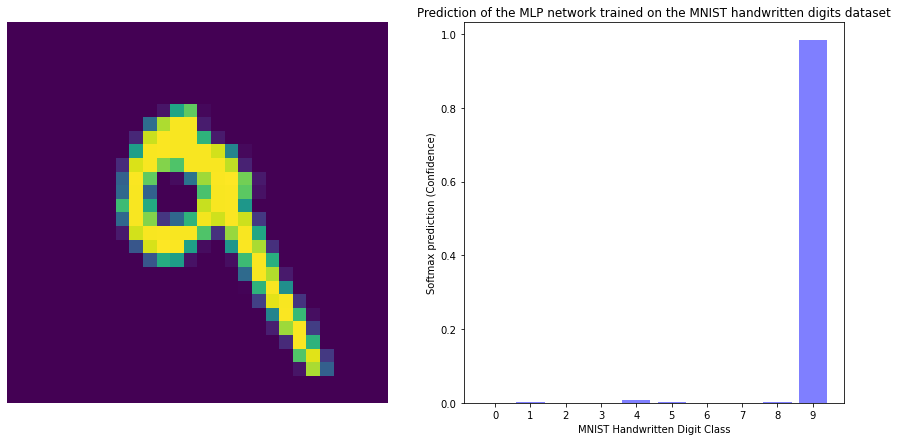

In [12]:
# create subplot to show input and its prediction
plt.figure(figsize=(15,7))

index = 7
test_input = test_images[index,:,:]


# MNIST test input (1st subplot)
plt.subplot(1,2,1)
plt.imshow(test_input.reshape(28,28))
plt.axis('off')

# bar chart (2nd subplot)
plt.subplot(1,2,2)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# prepare input to cnn
cnn_test_input = test_images[index]
cnn_test_input = cnn_test_input.reshape(1,28,28,1)
prediction = model.predict(cnn_test_input)
prediction = prediction[0,:].tolist() # convert prediction array into list to plot on chart

plt.bar(class_names, prediction, align='center', alpha=0.5, color='blue')
plt.xticks(class_names, class_names)
plt.xlabel('MNIST Handwritten Digit Class')
plt.ylabel('Softmax prediction (Confidence)')
plt.title('Prediction of the MLP network trained on the MNIST handwritten digits dataset')

plt.show()